In [1]:
import sys
sys.path.insert(0, './..')
sys.path.insert(0, '../data')

import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
from matplotlib.ticker import FormatStrFormatter

import plotly.graph_objects as go
import matplotlib.pyplot as plt
import proplot as pplt
import numpy as np
import plots as pl
import torch
from robustness1.datasets import CIFAR
import dill
from utils import dev, load_data, classification, make_orth_basis, orth_check

from models import model as model_loader
import tqdm
import seaborn as sns
titlesize = 10
fontsize = 8
cm = 1/2.54
figwidth = 13.968*cm
dpi = 600
params = {'legend.fontsize': fontsize,
          'legend.title_fontsize': fontsize,
          'font.family': 'serif',
         'axes.labelsize': fontsize,
         'axes.titlesize':titlesize,
         'xtick.labelsize':fontsize,
         'ytick.labelsize':fontsize}
plt.rcParams.update(params)

def tab_name_to_hex(tab): 
    conv_table = {
        "tab:blue": "#1f77b4",
        "tab:orange": "#ff7f0e",
        "tab:green": "#2ca02c",
        "tab:red": "#d62728",
        "tab:purple": "#9467bd",
        "tab:brown": "#8c564b",
        "tab:pink": "#e377c2",
        "tab:gray": "#7f7f7f",
        "tab:grey": "#7f7f7f",
        "tab:olive": "#bcbd22",
        "tab:cyan": "#17becf",
    }
    return conv_table[tab.lower()]

plot_colors = [tab_name_to_hex('tab:blue'), 
               tab_name_to_hex('tab:red'), 
               tab_name_to_hex('tab:green'), 
               tab_name_to_hex('tab:orange'), 
               tab_name_to_hex('tab:purple'), 
               tab_name_to_hex('tab:brown'), 
               tab_name_to_hex('tab:pink'), 
               tab_name_to_hex('tab:gray'), 
               tab_name_to_hex('tab:olive'), 
               tab_name_to_hex('tab:cyan')]    

In [2]:
def plot_boxplot(pert_lengths, n=10, labels=None, showmeans=False, ax=None):
    n = np.minimum(n, pert_lengths[0].shape[1])
    pert_lengths = [p[:,:n] for p in pert_lengths]
    colors = plot_colors
    l = []
    offset = [-.4,.4]
    plt.sca(ax)

    for i, pl in enumerate(pert_lengths):
        boxprops = dict(color=colors[i], linewidth=.5, alpha=1)
        whiskerprops = dict(color=colors[i], alpha=0.7)
        capprops = dict(color=colors[i], alpha=0.7)
        medianprops = dict(linestyle='--', linewidth=.5, color=colors[i])
        meanprops = dict(linestyle='-', linewidth=.5, color=colors[i])


        if not labels is None:
            l.append(mpatches.Patch(color=colors[i], label=labels[i]))

        pl[pl==0] = np.nan
        mask = ~np.isnan(pl)
        filtered_data = [d[m] for d, m in zip(pl.T, mask.T)]
        plt.boxplot(filtered_data, positions=np.array(range(len(filtered_data)))*len(pert_lengths) + offset[i], sym='', widths=0.6,
                   whis=[10,90], showfliers=False, meanline=showmeans, showmeans=showmeans, boxprops=boxprops, 
                   whiskerprops=whiskerprops, capprops=capprops, meanprops=meanprops,  medianprops=medianprops)
#     ax.set_title('Perturbation length of first ' + str(n) + ' adversarial directions')
    ax.set_ylabel('adversarial vector length')
    ax.set_xticks(np.arange(0,n*len(pert_lengths),len(pert_lengths)))
    ax.set_xticklabels(np.arange(1,n+1))
    ax.tick_params(axis='x', which='minor', bottom=False)
    ax.xaxis.grid(False)
    if not (labels is None):
        leg = ax.legend(handles=l, frameon=False)
        leg.get_frame().set_linewidth(0.0)
    return 

# Load models

In [3]:
ds = CIFAR('../data/cifar-10-batches-py')
classifier_model = ds.get_model('resnet50', False)
model_natural = model_loader.cifar_pretrained(classifier_model, ds)

resume_path = '../models/cifar_models/nat_diff.pt'
checkpoint = torch.load(resume_path, pickle_module=dill, map_location=torch.device(dev()))

state_dict_path = 'model'
if not ('model' in checkpoint):
    state_dict_path = 'state_dict'
sd = checkpoint[state_dict_path]
sd = {k[len('module.'):]: v for k, v in sd.items()}
model_natural.load_state_dict(sd)
model_natural.to(dev())
model_natural.double()
model_natural.eval()

classifier_model = ds.get_model('resnet50', False)
model_robust = model_loader.cifar_pretrained(classifier_model, ds)

resume_path = '../models/cifar_models/rob_diff.pt'
checkpoint = torch.load(resume_path, pickle_module=dill, map_location=torch.device(dev()))

state_dict_path = 'model'
if not ('model' in checkpoint):
    state_dict_path = 'state_dict'
sd = checkpoint[state_dict_path]
sd = {k[len('module.'):]:v for k,v in sd.items()}
model_robust.load_state_dict(sd)
model_robust.to(dev())
model_robust.double()
model_robust.eval()

Custom model
Custom model


cifar_pretrained(
  (normalizer): InputNormalize()
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layer1): SequentialWithArgs(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (shortcut): Sequential(
          (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(256, eps=1e-05,

# Load data

In [4]:
# load data
data_nat = np.load('../data/cifar_natural_diff.npy', allow_pickle=True).item()
advs = data_nat['advs']
pert_lengths = data_nat['pert_lengths']
classes = data_nat['adv_class']
dirs = data_nat['dirs']
images = data_nat['images']
labels = data_nat['labels']
pert_lengths = data_nat['pert_lengths']

data_madry = np.load('../data/cifar_robust_diff.npy', allow_pickle=True).item()
images_madry = data_madry['images']
labels_madry = data_madry['labels']
advs_madry = data_madry['advs']
pert_lengths_madry = data_madry['pert_lengths']
classes_madry = data_madry['adv_class']
dirs_madry = data_madry['dirs']

cifar_labels = ['airplane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

data_dist = np.load('../data/dists_to_bnd_natural.npy', allow_pickle=True).item()
dists_natural = data_dist['dists']
angles_natural = data_dist['angles']
largest_vecs_natural = data_dist['largest_vecs']

data_dist_madry = np.load('../data/dists_to_bnd_robust.npy', allow_pickle=True).item()
dists_robust = data_dist_madry['dists']
angles_robust = data_dist_madry['angles']
largest_vecs_robust = data_dist_madry['largest_vecs']            
              
dists_natural[dists_natural==0]=np.nan
dists_robust[dists_robust==0]=np.nan

angles_natural[np.isnan(dists_natural)]=np.nan
angles_robust[np.isnan(dists_robust)]=np.nan

# Plot grid of adversarial examples

In [ ]:
array = [
    range(1,12),
    range(12,23),
    range(23,34),
    range(34,45),
    range(45,56)
]
hspace = [1,]*4
wspace =  [1, 0.2,]*5
n_images = 5

fig, ax = pplt.subplots(array, sharey=False, sharex=False, dpi=100,
                          wspace=wspace, hspace=hspace, figwidth=figwidth, top=3)

img_idcs = [81, 20, 1 ,77, 63]
# img_idcs = np.random.choice(np.arange(100), size=n_images, replace=False)

ax[0].set_title('Original', fontsize=7)
ax_idx=0
for i, img_n in enumerate(img_idcs):
    ax[ax_idx].imshow(np.transpose(images[img_n].reshape((3,32,32)), (1,2,0)))
    ax[ax_idx].set_xlabel(cifar_labels[int(labels[img_n])], fontsize=5)
    ax[ax_idx].xaxis.set_label_coords(0.5, -0.05)
    ax[ax_idx].set_xticks([])
    ax[ax_idx].set_yticks([])
    for pos in ['top', 'left', 'right', 'bottom']:
        ax[ax_idx].spines[pos].set_visible(False)

    ax_idx+=1
    for j in range(n_images):
        ax[ax_idx].imshow(np.transpose(advs[img_n,j*10].reshape((3,32,32)), (1,2,0)))
        for pos in ['top', 'left', 'right', 'bottom']:
            ax[ax_idx].spines[pos].set_visible(False)
        ax[ax_idx].set_xticks([])
        ax[ax_idx].set_yticks([])
#         ax[ax_idx].set_xlabel(cifar_labels[int(classes[img_n,j*10])]+ ', $\ell_2$=%.2f' % (pert_lengths[img_n, j*10]), fontsize=4)
        ax[ax_idx].set_xlabel(cifar_labels[int(classes[img_n,j*10])]+ ' (%.2f)' % (pert_lengths[img_n, j*10]), fontsize=5)
        ax[ax_idx].xaxis.set_label_coords(0.5, -0.05)
        if i == 0:
            ax[ax_idx].set_title('Natural', fontsize=7)
        
        ax_idx+=1
        if i == 0:
            ax[ax_idx].set_title('Robust', fontsize=7)
        ax[ax_idx].imshow(np.transpose(advs_madry[img_n,j*10].reshape((3,32,32)), (1,2,0)))
        ax[ax_idx].set_xticks([])
        ax[ax_idx].set_yticks([])
        for pos in ['top', 'left', 'right', 'bottom']:
            ax[ax_idx].spines[pos].set_visible(False)
        ax[ax_idx].set_xlabel(cifar_labels[int(classes_madry[img_n,j*10])]+ ' (%.2f)' % (pert_lengths_madry[img_n, j*10]), fontsize=5)
        ax[ax_idx].xaxis.set_label_coords(0.5, -0.05)
        ax_idx+=1

# the first two arguments to figtext are x and y coordinates in the figure system (0 to 1)
plt.figtext(.19,.96,"Adv 1", va="center", ha="center", size=8)
plt.figtext(.37,.96,"Adv 11", va="center", ha="center", size=8)
plt.figtext(.55,.96,"Adv 21", va="center", ha="center", size=8)
plt.figtext(.73,.96,"Adv 31", va="center", ha="center", size=8)
plt.figtext(.91,.96,"Adv 41", va="center", ha="center", size=8)

fig.savefig('../figures/cifar_examples.pdf', dpi=dpi, transparent=True, bbox_inches="tight", pad_inches=0.01)


# Perturbation Length comparison

In [5]:
n_dims=50
epsilons = np.arange(0,4,.001)
n_dims_natural = np.zeros((len(epsilons),len(images)))
n_dims_robust = np.zeros((len(epsilons),len(pert_lengths_madry[pert_lengths_madry[:,0]>0])))
for i, e in enumerate(epsilons):
    n_dims_natural[i] = (pert_lengths < e).sum(-1)
    n_dims_robust[i] = (pert_lengths_madry < e).sum(-1)

percentiles_natural = np.percentile(n_dims_natural, [10,90], axis=-1)
means_natural = np.mean(n_dims_natural,axis=-1)
errors_natural = percentiles_natural.copy()
errors_natural[0] = means_natural-percentiles_natural[0]
errors_natural[1] = percentiles_natural[1] - means_natural

percentiles_robust = np.percentile(n_dims_robust, [10,90], axis=-1)
means_robust = np.mean(n_dims_robust,axis=-1)
errors_robust = percentiles_robust.copy()
errors_robust[0] = means_robust-percentiles_robust[0]
errors_robust[1] = percentiles_robust[1] - means_robust

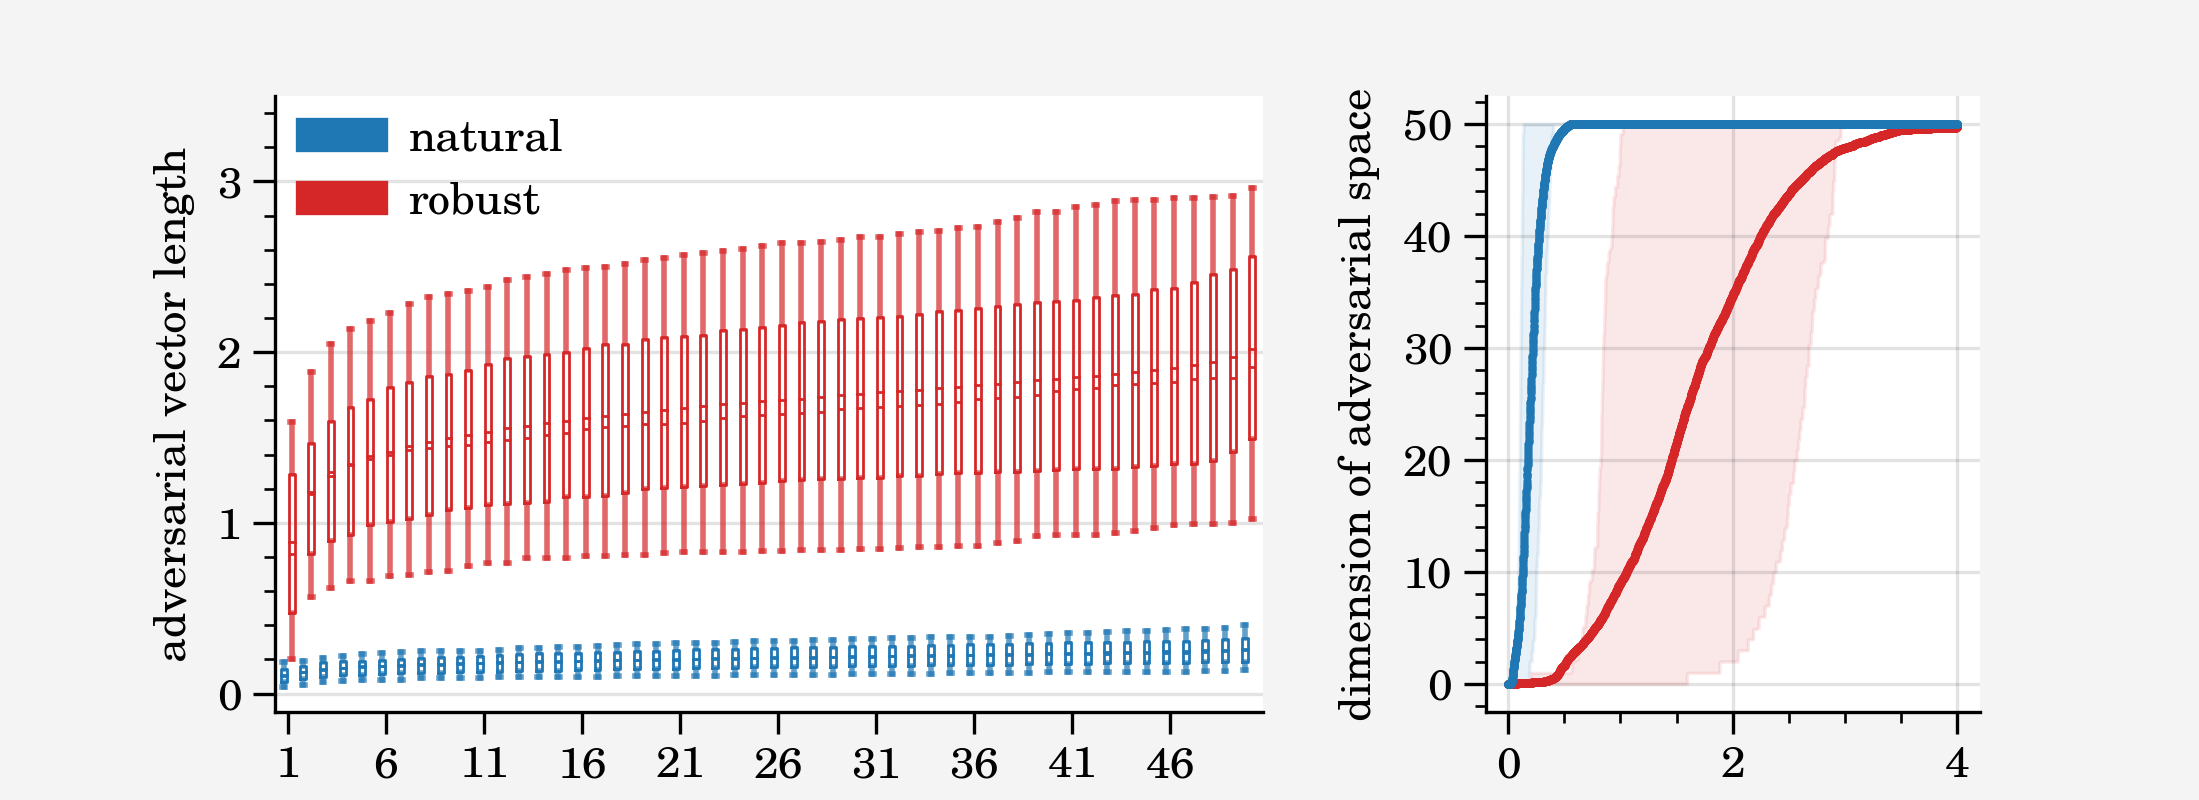

In [11]:

fig, axs = plt.subplots(1,2, figsize=(figwidth, 2), dpi=200, gridspec_kw={'width_ratios': [2,1]})
### only samples with at least n adversarials included
n=50

        
# plot with all adversarials included
plot_boxplot([pert_lengths,pert_lengths_madry],  n=n, labels=['natural','robust'], ax=axs[0], showmeans=True)
axs[0].set_ylim(top=3.5)
axs[0].set_xlim(-1.3,99.5)
axs[0].set_xticks(np.arange(0,2*n,2*5))
axs[0].set_xticklabels(np.arange(1,n+1,5))
axs[0].spines['right'].set_visible(False)
axs[0].spines['top'].set_visible(False)


axs[1].plot(epsilons, means_robust,'.', markersize=1,color=plot_colors[1],  label='robust')
axs[1].fill_between(epsilons, (means_robust-errors_robust[0]), (means_robust+errors_robust[1]), color=plot_colors[1], alpha=.1)
axs[1].plot(epsilons, means_natural,'.', markersize=1, color=plot_colors[0],   label='natural')
axs[1].fill_between(epsilons, (means_natural-errors_natural[0]), (means_natural+errors_natural[1]), color=plot_colors[0], alpha=.1)
axs[1].set_ylabel('dimension of adversarial space')
axs[1].set_xlabel('distance to decision boundary')
axs[1].spines['right'].set_visible(False)
axs[1].spines['top'].set_visible(False)
fig.subplots_adjust(wspace=.3)

fig.savefig('../figures/pert_lengths.pdf', dpi=dpi, transparent=True, bbox_inches="tight", pad_inches=0.01)

# Distance to decision boundary

/home/bethge/dschultheiss/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning:

Mean of empty slice

/home/bethge/dschultheiss/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning:

Mean of empty slice

/home/bethge/dschultheiss/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning:

All-NaN slice encountered

/home/bethge/dschultheiss/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning:

All-NaN slice encountered



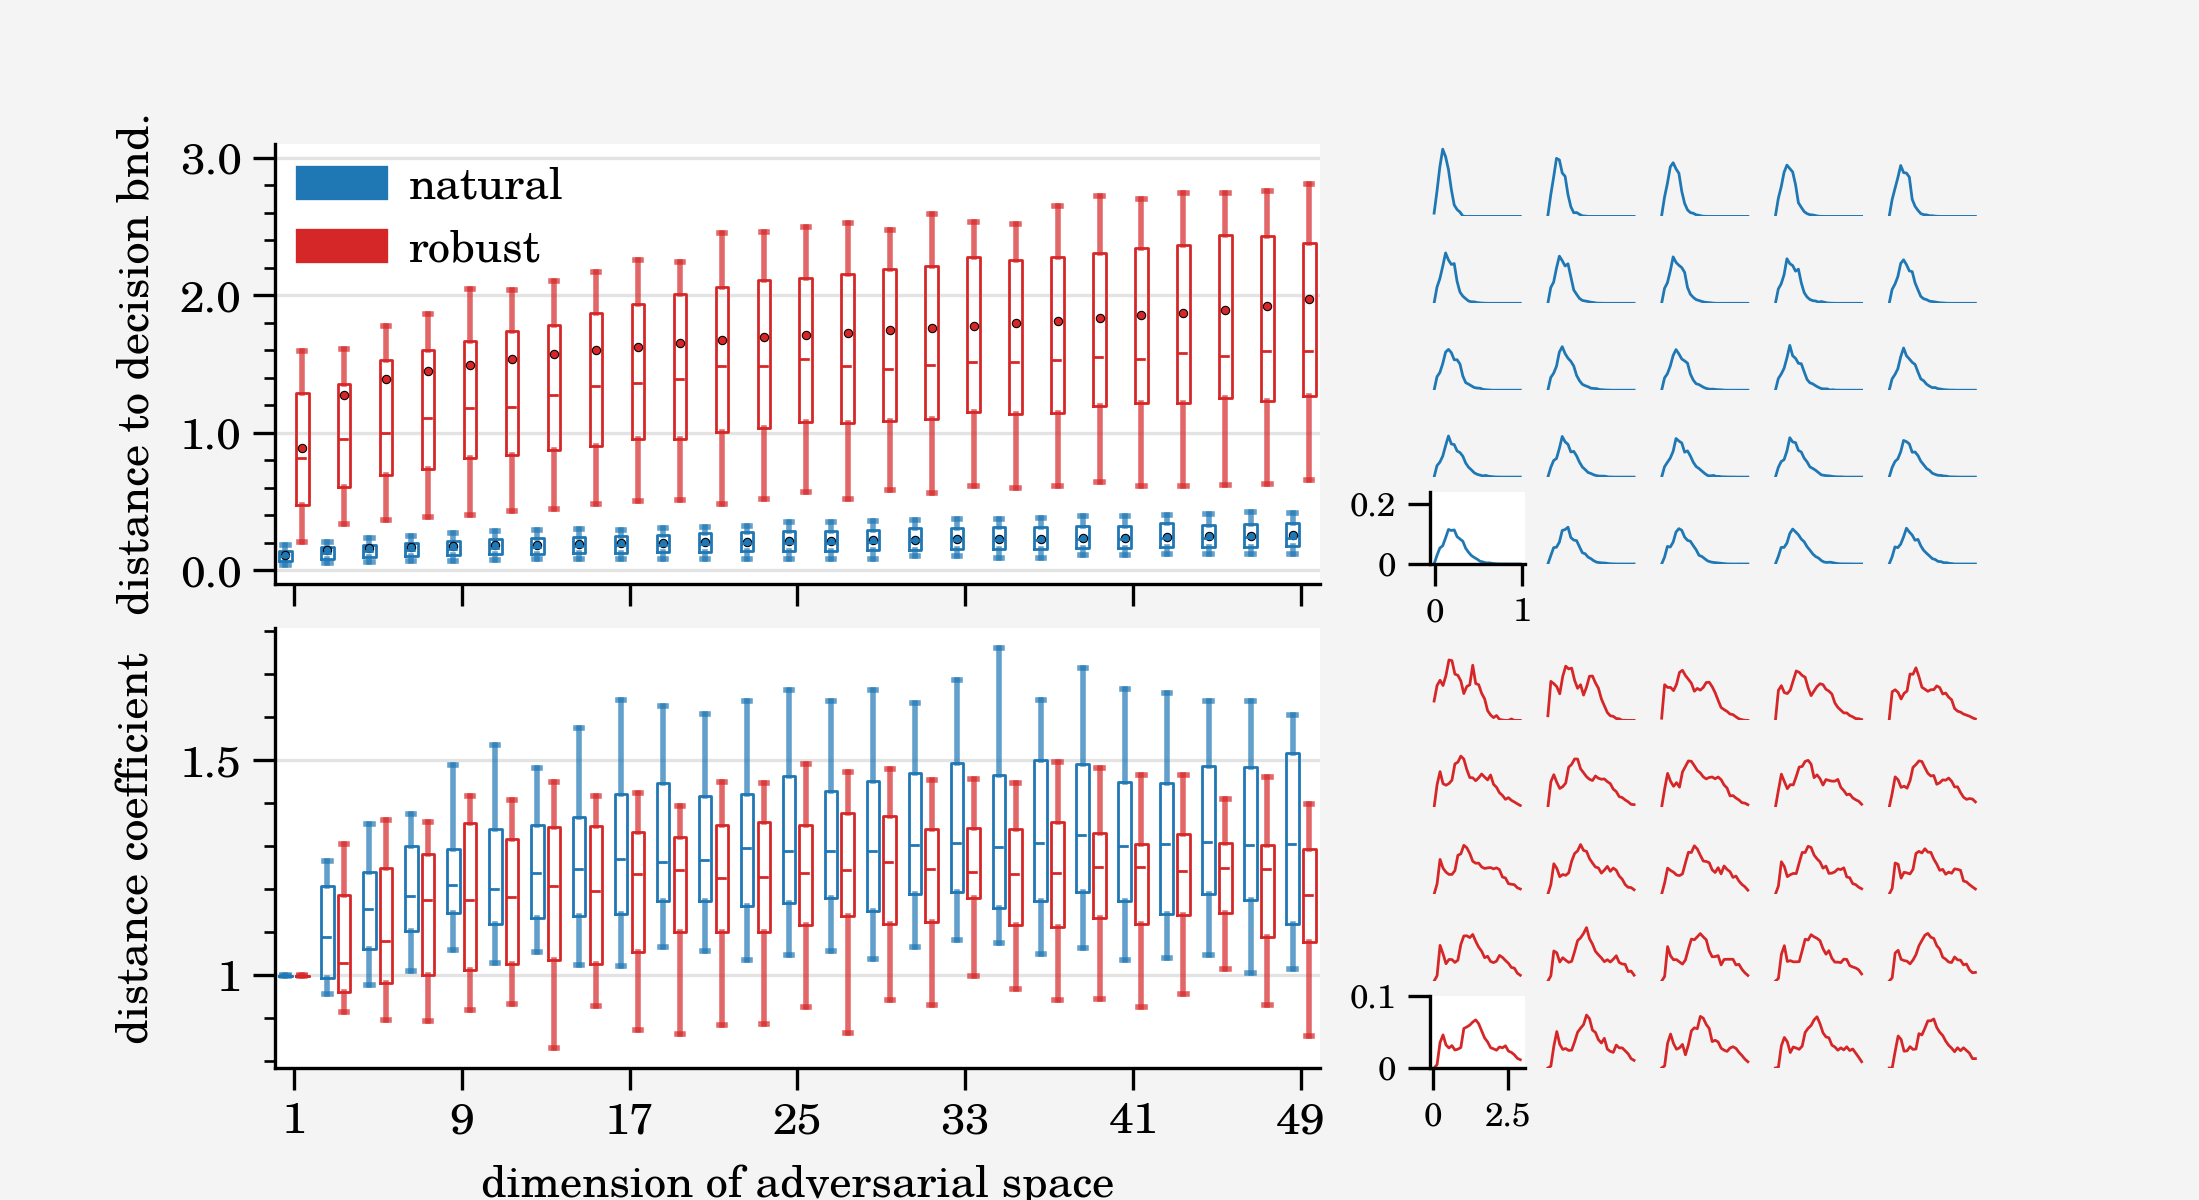

In [10]:
n_dims=25
mean_dists_natural = np.nanmean(dists_natural,axis=-1)
mean_dists_robust = np.nanmean(dists_robust,axis=-1)

max_dists_natural = np.nanmax(dists_natural,axis=-1)
max_dists_robust = np.nanmax(dists_robust,axis=-1)

dist_coeffs_natural = max_dists_natural/pert_lengths
dist_coeffs_robust = max_dists_robust/pert_lengths_madry


n_cols = 5
n_rows = 5

fig=plt.figure(figsize=(figwidth,3), dpi=200)
gs1 = fig.add_gridspec(2,1, hspace=.1, right=0.6)
gs2 = fig.add_gridspec(2,1, hspace=.2, left=0.65)
gs_r1 = gs2[0].subgridspec(n_rows, n_cols)
gs_r2 = gs2[1].subgridspec(n_rows, n_cols)

ax1 = fig.add_subplot(gs1[0])
ax2 = fig.add_subplot(gs1[1])

plot_boxplot([mean_dists_natural[:,::2],mean_dists_robust[:,::2]],  n=n_dims, labels=['natural','robust'], ax=ax1)
ax1.plot(np.arange(0,2*n_dims,2)+0.4,np.nanmean(pert_lengths_madry[:,::2], axis=0),'o',markeredgecolor='k', markeredgewidth=.2, markerfacecolor=plot_colors[1], ms=1.5)
ax1.plot(np.arange(0,2*n_dims,2)-0.4,np.nanmean(pert_lengths[:,::2], axis=0),'o',markeredgecolor='k', markeredgewidth=.2, markerfacecolor=plot_colors[0], ms=1.5)
ax1.set_ylabel('distance to decision bnd.')
ax1.set_xticks(np.arange(0,2*n_dims,8))
ax1.set_xticklabels('')
ax1.set_xticklabels('')
ax1.set_ylim(top=3.1)
ax1.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)


plot_boxplot([dist_coeffs_natural[:,::2],dist_coeffs_robust[:,::2]],  n=n_dims, ax=ax2)
# fig.text(0.4, -0.07, 'dimension of adversarial space', ha='center', fontsize=8)
ax2.set_ylabel('distance coefficient')
ax2.set_xticks(np.arange(0,2*n_dims,8))
ax2.set_xticklabels(np.arange(1,(2*n_dims)+1,8))
ax2.set_xlabel('dimension of adversarial space')
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)




for i in range(n_rows*n_cols):
    bins = np.arange(-0.025,1,.033)
    ax = fig.add_subplot(gs_r1[int(i/n_cols),(i%n_cols)])
    ax.set_ylim(0,.24)
    
    sns.histplot(x=dists_natural[:,i*2+1].flatten(), bins=bins, stat='probability', ax = ax, element='poly', fill=False, color=plot_colors[0], linewidth=.5)
    if i==20:
        ax.grid(False)
        ax.tick_params(axis='x', which='minor', bottom=False)
        ax.tick_params(axis='y', which='minor', left=False)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.set_ylabel('')
        ax.tick_params(axis='both', which='major', labelsize=6)
    else:
        ax.set_axis_off()
            
    
    bins = np.arange(-0.025,3,.1)
    ax = fig.add_subplot(gs_r2[int(i/n_cols),(i%n_cols)])
    sns.histplot(x=dists_robust[:,i*2+1].flatten(), bins=bins, stat='probability', ax = ax, element='poly', fill=False, color=plot_colors[1], linewidth=.5)
    ax.set_ylim(0,.1)
    if i==20:
        ax.grid(False)
        ax.tick_params(axis='x', which='minor', bottom=False)
        ax.tick_params(axis='y', which='minor', left=False)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.set_ylabel('')
        ax.tick_params(axis='both', which='major', labelsize=6)
    else:
        ax.set_axis_off()
    

plt.show()
fig.savefig('../figures/cifar_dists.pdf', dpi=dpi, transparent=True, bbox_inches="tight", pad_inches=0.01)

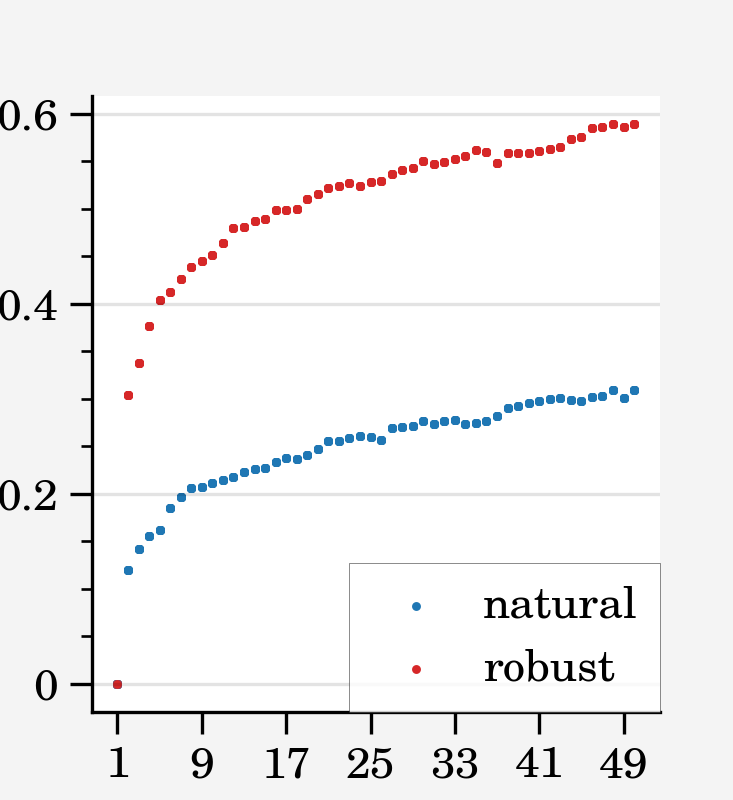

In [9]:
fig, ax = plt.subplots(figsize=(figwidth/3,2), dpi=200)
nans_nat = np.isnan(dists_natural).sum(-1).sum(0)/(dists_natural.shape[0]*dists_natural.shape[-1])
nans_rob = np.isnan(dists_robust).sum(-1).sum(0)/(dists_robust.shape[0]*dists_robust.shape[-1])
for dim in range(n_dims):
    ax.scatter(np.arange(1,51),nans_nat, c=plot_colors[0], s=1)
    ax.scatter(np.arange(1,51),nans_rob, c=plot_colors[1], s=1)
ax.set_xticks(np.arange(1,51,8))
ax.set_xticklabels(np.arange(1,50+1,8))
ax.tick_params(axis='x', which='minor', bottom=False)
ax.xaxis.grid(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('dimension of adversarial sapce')
ax.set_ylabel('out of bounds ratio')
leg = ax.legend(labels=['natural','robust'], frameon=True)
leg.get_frame().set_linewidth(0.1)
fig.savefig('../figures/cifar_bnd_ratio.pdf', dpi=dpi, transparent=True, bbox_inches="tight", pad_inches=0.01)

RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 10.76 GiB total capacity; 2.28 GiB already allocated; 20.56 MiB free; 2.30 GiB reserved in total by PyTorch)

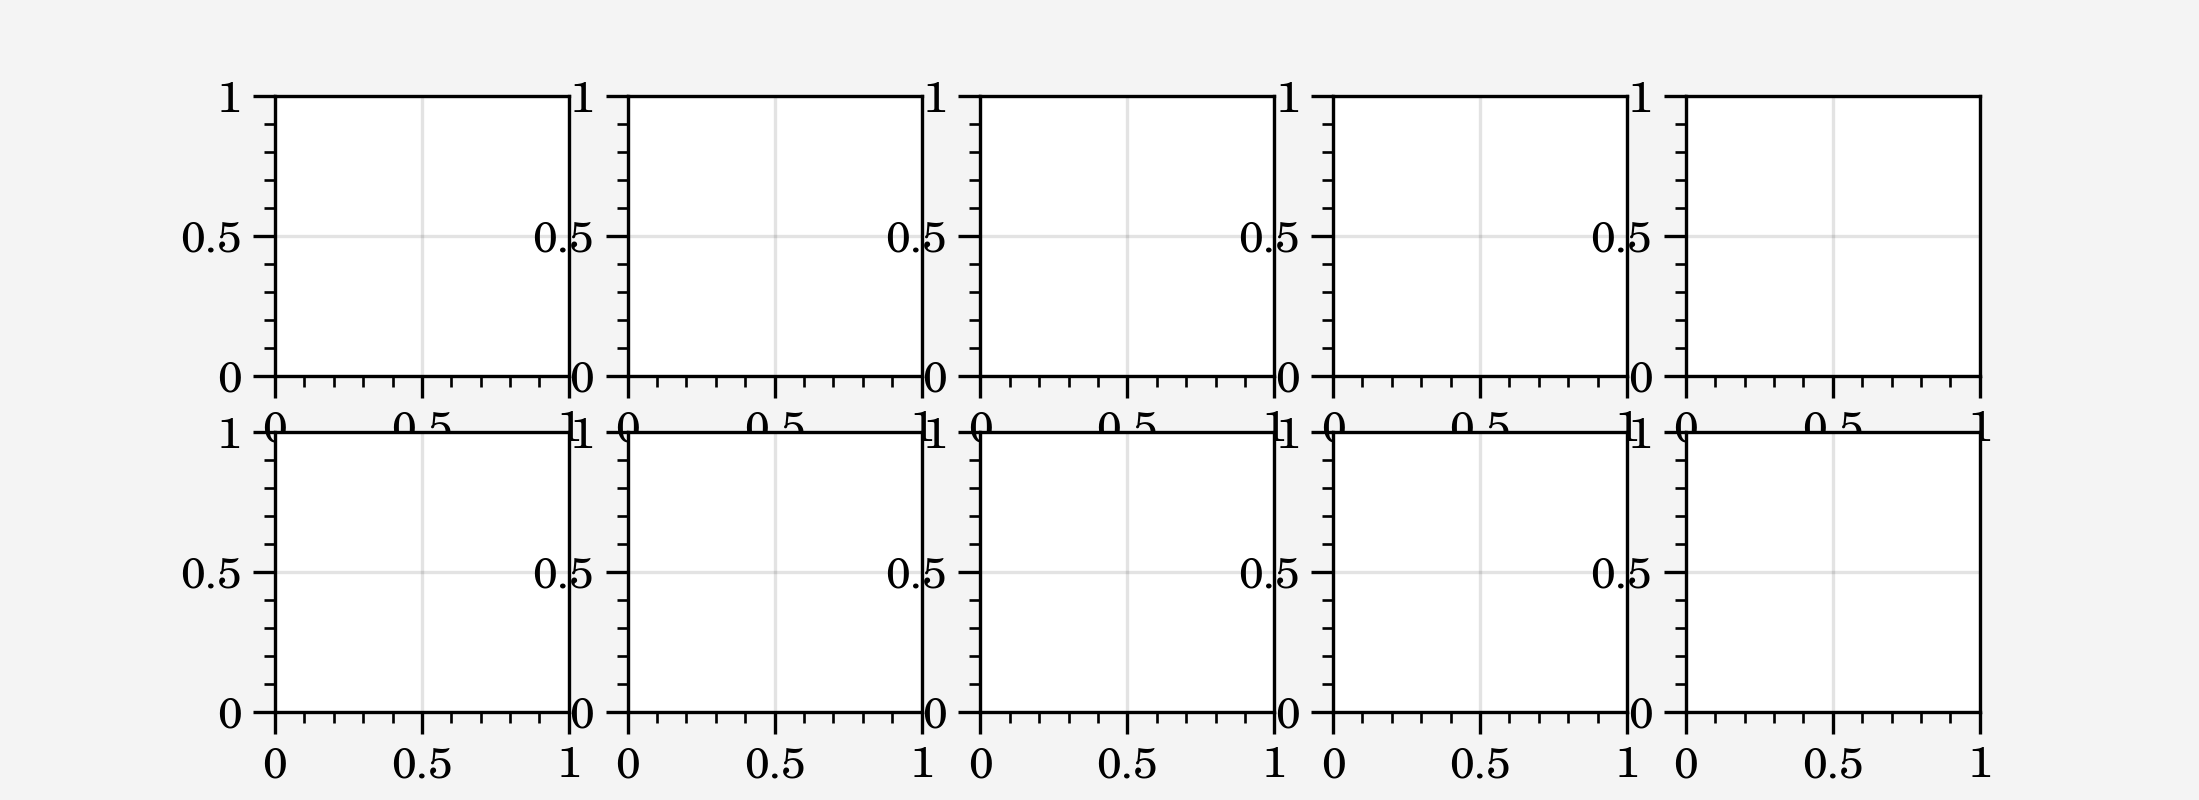

In [133]:
n_dims = 50
n_rows = 2
n_cols = 5



coeffs = dists_natural[:,1:]/pert_lengths[:,1:,None]
idcs=[]
max_coeffs = []
for i, c in enumerate(coeffs): 
    idx = np.unravel_index(np.nanargmax(coeffs[i].ravel()), coeffs[i].shape)
    max_coeffs.append(c[idx])
    idx = (idx[0]+1, idx[1])
    idcs.append((i,) + idx)
    

idcs = [idcs[idx] for idx in np.argsort(max_coeffs)]
max_coeffs = [max_coeffs[idx] for idx in np.argsort(max_coeffs)]

plt_idcs = np.linspace(10,len(idcs)-1,n_rows*n_cols) 

fig, axs = plt.subplots(n_rows,n_cols, figsize=(figwidth,2), dpi=200)
for i, idx in enumerate(plt_idcs):
    img_idx=idcs[int(idx)]
    vec = largest_vecs_natural[img_idx[:-1]]
    vec_orth = vec - (vec*dirs[img_idx[:-1]]).sum()*dirs[img_idx[:-1]]
    vec_orth = vec_orth/np.linalg.norm(vec_orth)
    orig = images[img_idx[0]]
    adv1 = advs[img_idx[:-1]]
    adv2 = orig.flatten() + vec_orth*dists_natural[img_idx]
    model_ = model_natural
    plot_dec_space(orig, adv1, adv2, model_natural,n_grid=100, offset=dists_natural[img_idx]/3, arrows=[vec*dists_natural[img_idx]],
                      len_grid_scale=1.5, overlay_inbounds=True, show_legend=True,  show_advs=True, ax = axs[int(i/n_cols),(i%n_cols)])
    axs[int(i/n_cols),(i%n_cols)].tick_params(axis='x', which='minor', bottom=False)
    axs[int(i/n_cols),(i%n_cols)].tick_params(axis='y', which='minor', left=False)
    axs[int(i/n_cols),(i%n_cols)].tick_params(axis='x', which='major', length=1)
    axs[int(i/n_cols),(i%n_cols)].tick_params(axis='y', which='major', length=1)

    axs[int(i/n_cols),(i%n_cols)].text(.72, 0.83,'%.2f' % (max_coeffs[int(idx)]),transform=axs[int(i/n_cols),(i%n_cols)].transAxes,  fontsize=5, bbox= dict(facecolor='white', alpha=.5, pad=2))
    axs[int(i/n_cols),(i%n_cols)].text(.3, 0.05,'adv dir %d' % (img_idx[1]+1),transform=axs[int(i/n_cols),(i%n_cols)].transAxes,  fontsize=5)
    

handles = []
for i, c in enumerate(range(10)):
    handles.append(mpatches.Patch(color=plot_colors[c], label=cifar_labels[c]))
leg = fig.legend(handles=handles, loc = 'right', bbox_to_anchor=(1, .5), prop={"size":5})
leg.set_title('predicted \nclass',prop={'size':5})
fig.subplots_adjust(wspace=.2,hspace=.2, right=0.9,)
plt.show()
fig.savefig('../figures/cifar_dec_space.pdf', dpi=dpi, transparent=True, bbox_inches="tight", pad_inches=0.01)

In [9]:
def plot_dec_space(orig, adv1, adv2, model, offset=0.1, len_grid_scale=2, n_grid=100, show_legend=True, show_advs=True,
                   overlay_inbounds=False, origin_centered=False, ax=None, arrows=None):
    if ax is None:
        fig, ax = plt.subplots()
    shape = orig.shape
    orig = orig.flatten()
    pert1 = adv1 - orig
    pert2 = adv2 - orig
    len1 = np.linalg.norm(pert1)
    len2 = np.linalg.norm(pert2)
    dir1 = pert1 / len1
    dir2 = pert2 / len2

    len_grid = len_grid_scale * np.maximum(len1,len2)
    if origin_centered:
        offset=len_grid

    x = np.linspace(-offset, len_grid, n_grid)
    y = np.linspace(-offset, len_grid, n_grid)
    X, Y = np.meshgrid(x, y)
    advs = orig + (dir1[None, :] * np.reshape(X, (-1, 1)) + dir2[None, :] * np.reshape(Y, (-1, 1)))
    advs = np.array(np.reshape(advs, ((-1,) + shape)).astype('float64'))
    input = torch.split(torch.tensor(advs, device=dev()), 20)

    preds = np.empty((0, 10))
    for batch in input:
        preds = np.concatenate((preds, model(batch).detach().cpu().numpy()), axis=0)

    classes = np.argmax(preds, axis=-1).reshape((n_grid, n_grid))
    
    # Plot the surface.
    new_cmap = ListedColormap(plot_colors)

    ax.imshow(classes, cmap=new_cmap, origin='lower', vmin=0, vmax=9)
    if overlay_inbounds:
        new_cmap2 = ListedColormap(['none', 'k'])
        out_of_bounds = np.logical_or(advs.max(axis=(1,2,3))>1, advs.min(axis=(1,2,3))<0).reshape((n_grid, n_grid))
        ax.imshow(out_of_bounds, cmap=new_cmap2, origin='lower', alpha=.5, vmin=0, vmax=1)

    ax.axvline(offset*n_grid/(offset+len_grid), c='k', ls='--', alpha=0.5, linewidth=.5)
    ax.axhline(offset*n_grid/(offset+len_grid), c='k', ls='--', alpha=0.5, linewidth=.5)

    ax.plot(offset*n_grid/(offset+len_grid), offset*n_grid/(offset+len_grid),
             markeredgecolor='black', markerfacecolor='black', marker='o', markersize=1.5, markeredgewidth=.2)
    
    if not arrows is None:
        arrow_width = 0.0
        arrow_linewidth = 1
        arrow_headsize = 3
        arrow_head_length = 3
        arrow_head_width = 3
        for arrow in arrows:
            arr_x = (dir1* arrow).sum()
            arr_y = (dir2 * arrow).sum()
            vect_x = (arr_x) * n_grid / (offset + len_grid)
            vect_y = (arr_y) * n_grid / (offset + len_grid)
            ax.arrow(offset*n_grid/(offset+len_grid), offset*n_grid/(offset+len_grid), vect_x, vect_y,
                width=arrow_width, head_width=arrow_head_width, head_length=arrow_head_length,
                fc='k', ec='k', linestyle='-', linewidth=arrow_linewidth, length_includes_head=True)

    if show_advs:
        adv_locs = [
            [
                offset * n_grid / (offset + len_grid),
                (offset + len1) * n_grid / (offset + len_grid)
            ],[
                (offset + len2) * n_grid / (offset + len_grid),
                offset * n_grid / (offset + len_grid)
            ]
        ]
        ax.plot(adv_locs[0][1], adv_locs[0][0],
                 markeredgecolor='black', markerfacecolor='red', marker='o', markersize=1.5, markeredgewidth=.2)
#         ax.plot(adv_locs[1][1], adv_locs[1][0],
#                  markeredgecolor='black', markerfacecolor='red', marker='o')


    data_ticks = np.linspace(offset*n_grid/(offset+len_grid), (offset+0.9*len_grid)*n_grid/(offset+len_grid), 3)
    plot_ticks = [np.round(x, 2).astype(str) for x in np.linspace(0, 0.9*len_grid, 3)]
    ax.set_xticks(data_ticks, minor=False)
    ax.set_xticklabels(plot_ticks, fontsize=4)
    ax.set_yticks(data_ticks, minor=False)
    ax.set_yticklabels(plot_ticks, fontsize=4)

    
    if ax is None:
        return fig, ax, advs, labels
    else:
        return advs, labels

# Additional Stuff

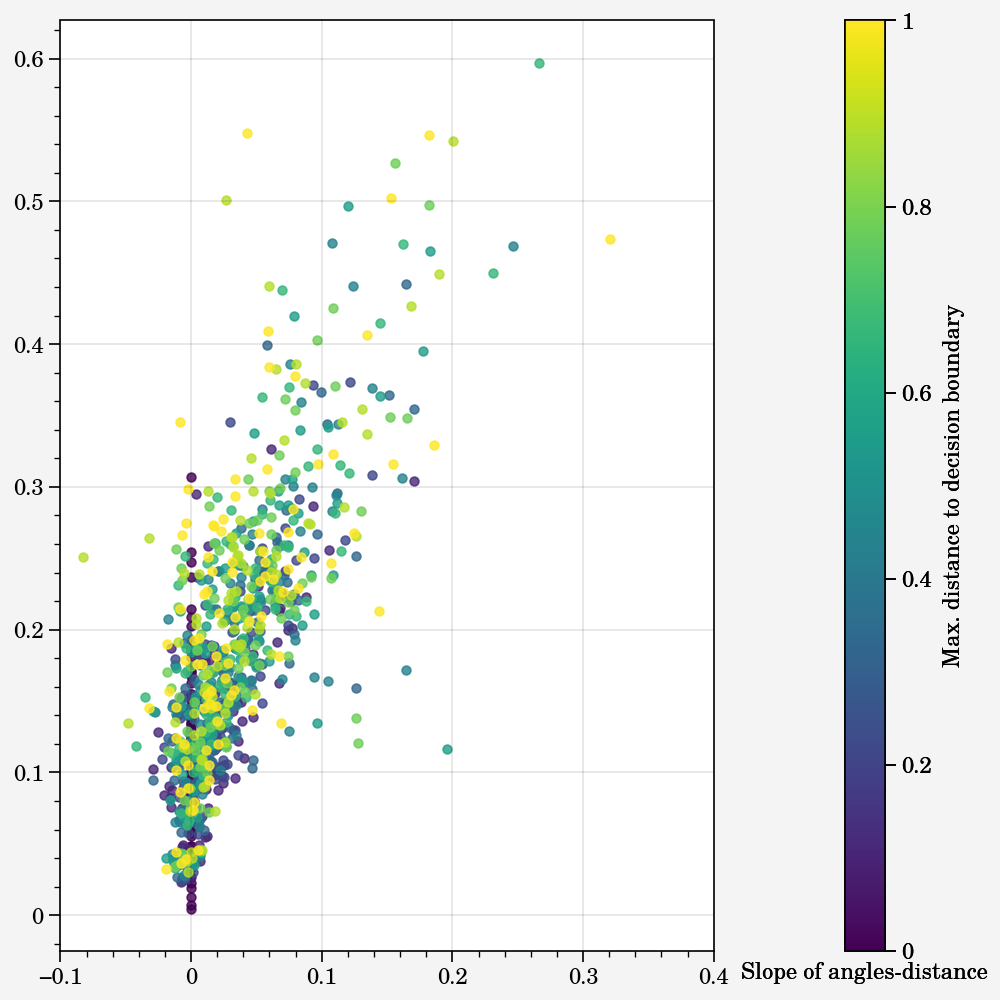

In [72]:
import warnings
warnings.simplefilter('ignore', np.RankWarning)
n_cols = 7
n_rows = 7


# slopes_natural = np.zeros(dists_natural.shape[:-1])
# slopes_robust = np.zeros(dists_natural.shape[:-1])

# for img_n in range(len(dists_natural)):
#     for dim in range(1,dists_natural.shape[1]):
#         if np.all(np.isnan(dists_natural[img_n,dim])):
#             slopes_natural[img_n, dim] = np.nan
#         else:
#             angles_ = angles_natural[img_n,dim][np.isfinite(dists_natural[img_n,dim])]
#             dists_ = dists_natural[img_n,dim][np.isfinite(dists_natural[img_n,dim])]
#             slopes_natural[img_n, dim] = np.polyfit(angles_, dists_, deg=1)[0]
#         if np.all(np.isnan(dists_robust[img_n,dim])):
#             slopes_robust[img_n, dim] = np.nan
#         else:
#             angles_ = angles_robust[img_n,dim][np.isfinite(dists_robust[img_n,dim])]
#             dists_ = dists_robust[img_n,dim][np.isfinite(dists_robust[img_n,dim])]
#             slopes_robust[img_n, dim] = np.polyfit(angles_, dists_, deg=1)[0]


# fig, axs = pplt.subplots(nrows=n_rows, ncols=n_cols)
# axs.format(
#     xlabel='slope of minimum angle vs distance to dec boundary', ylabel='n')    
# # fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols,n_rows,), sharex=True, sharey=True)            
# for i in range(n_rows*n_cols):
#     axs[int(i/n_cols),(i%n_cols)].hist(slopes_natural[:,i+1].flatten(), bins=np.arange(-0.1,3,.1), color='blue', alpha=.5)
#     axs[int(i/n_cols),(i%n_cols)].hist(slopes_robust[:,i+1].flatten(), bins=np.arange(-0.1,3,.1), color='orange', alpha=.5)
# #     axs[int(i/n_cols),(i%n_cols)].invert_xaxis()
# plt.show()


n_dims=10
col_range = np.linspace(0,1,n_dims, endpoint=True)
cmap=plt.get_cmap('viridis')
colors = [cmap(x) for x in col_range]
fig, ax = pplt.subplots(figsize=(5,5))
for dim in range(n_dims):
    ax.scatter(slopes_natural[:,dim], max_dists_natural[:,dim], s=10, color=colors[dim], alpha=.8)
# plt.ylim(-.01,.4)
plt.xlim(-.1,.4)
plt.colorbar(cmap)
plt.ylabel('Max. distance to decision boundary')
plt.xlabel('Slope of angles-distance')
plt.show()



/home/bethge/dschultheiss/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning:

Mean of empty slice

/home/bethge/dschultheiss/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning:

Mean of empty slice

/home/bethge/dschultheiss/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning:

All-NaN slice encountered

/home/bethge/dschultheiss/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning:

All-NaN slice encountered

/home/bethge/dschultheiss/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning:

Mean of empty slice

/home/bethge/dschultheiss/.local/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning:

Mean of empty slice



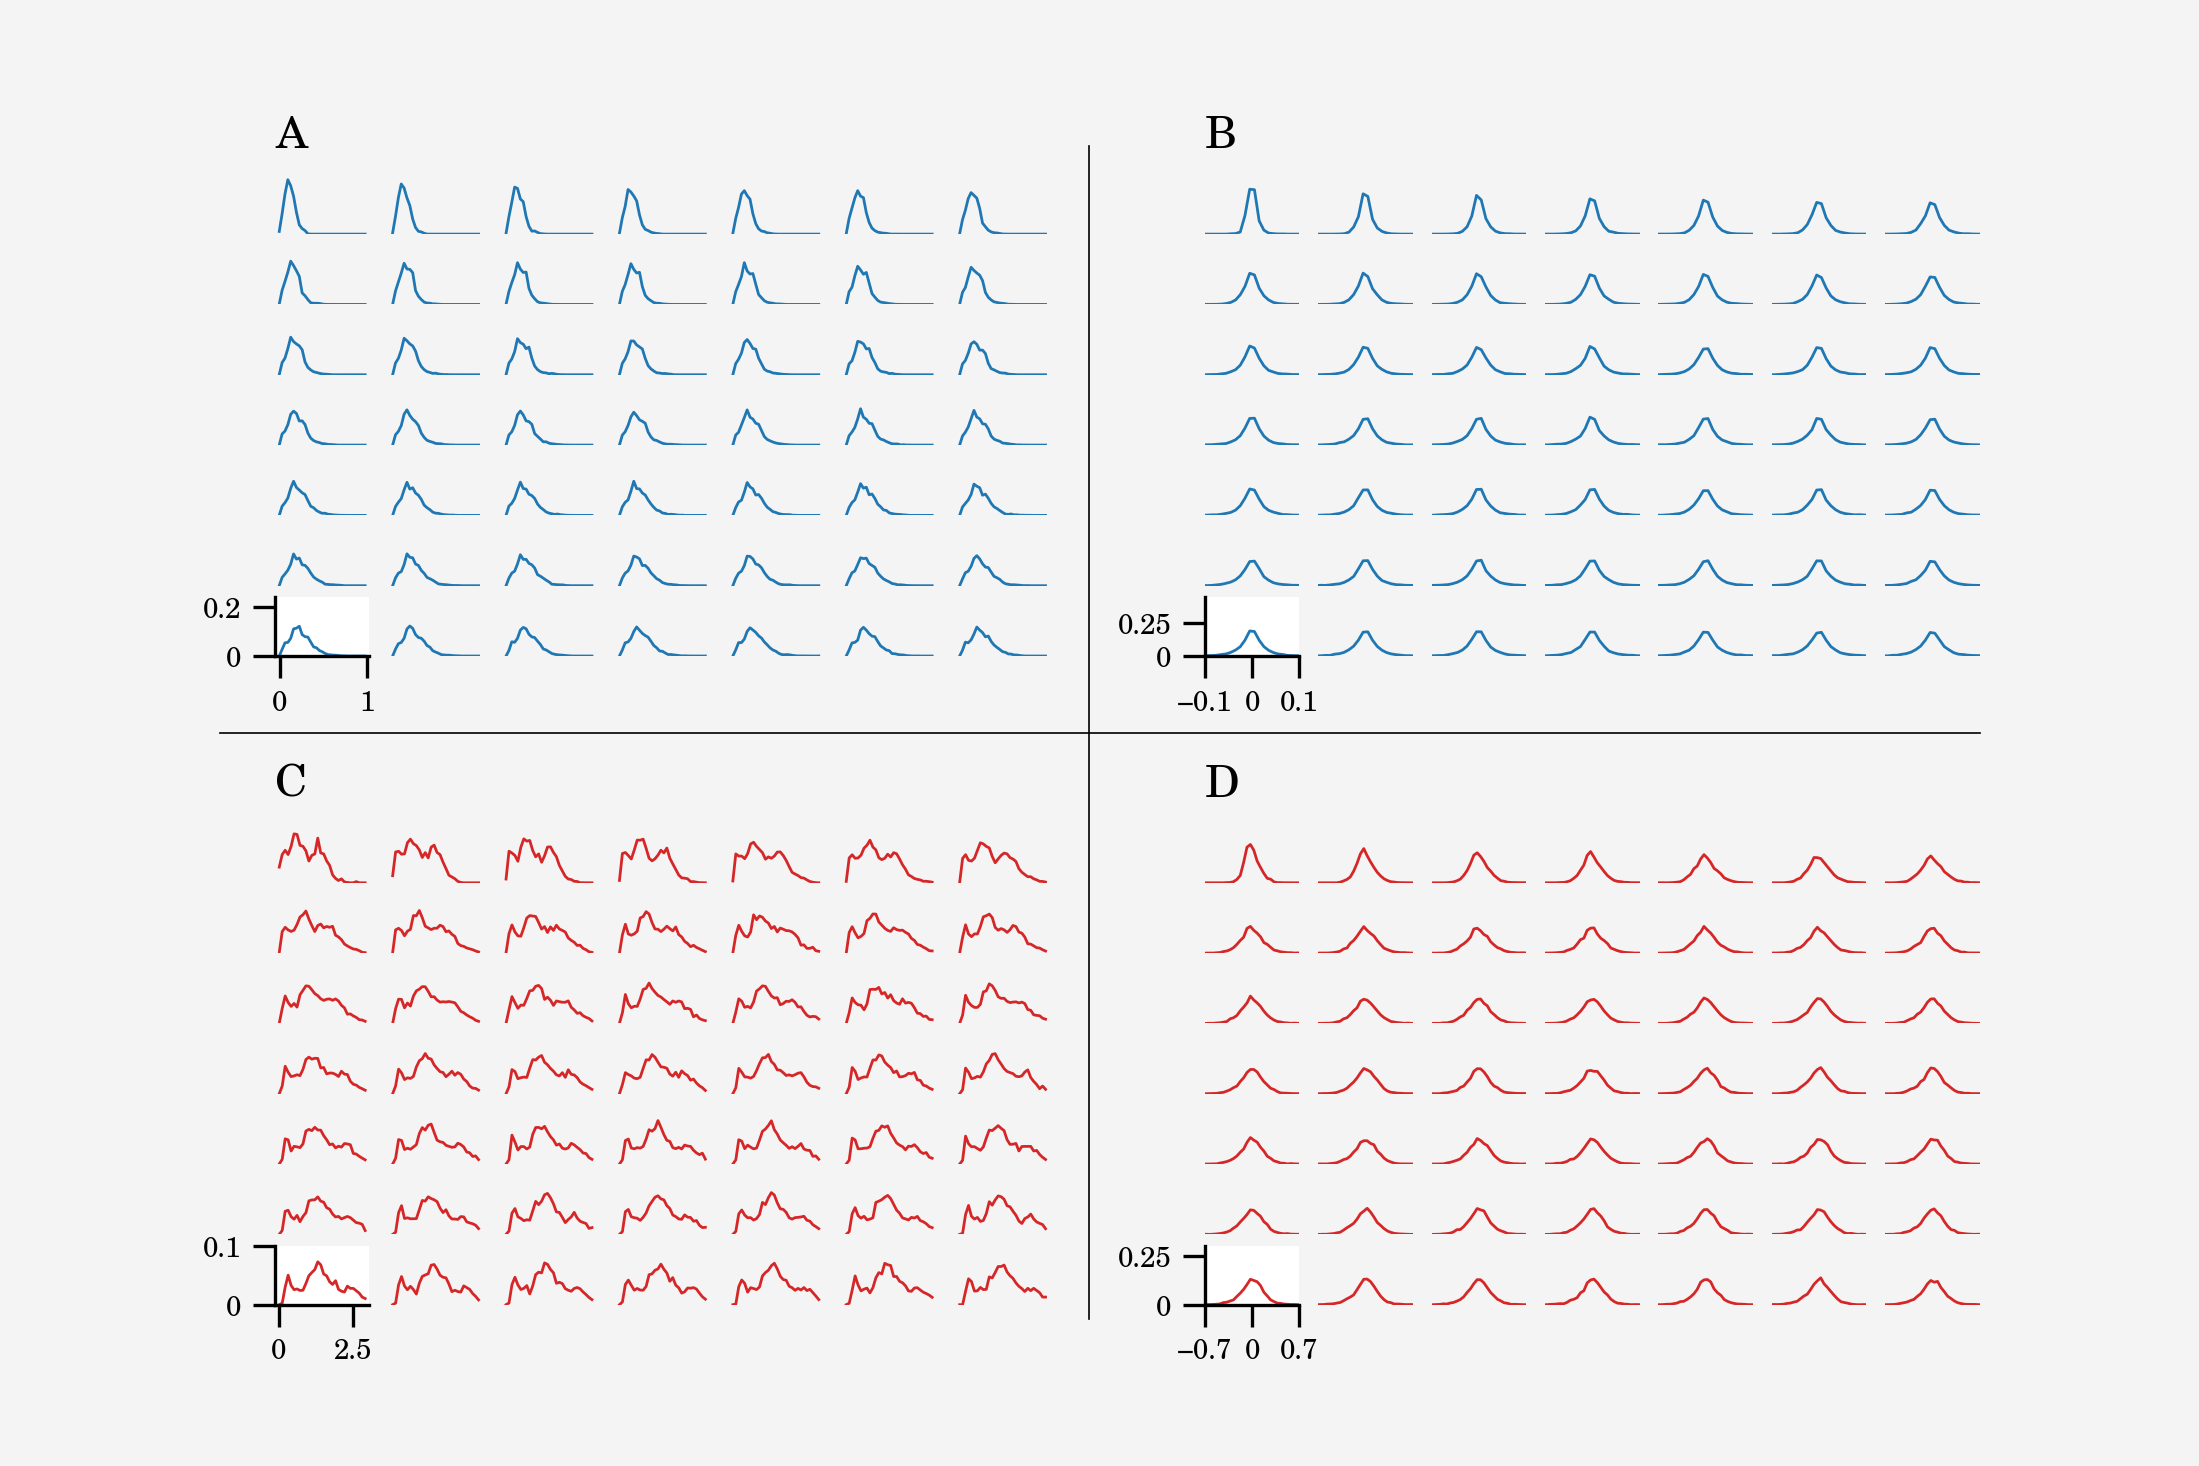

In [132]:
n_dims=50
mean_dists_natural = np.nanmean(dists_natural,axis=-1)
mean_dists_robust = np.nanmean(dists_robust,axis=-1)

max_dists_natural = np.nanmax(dists_natural,axis=-1)
max_dists_robust = np.nanmax(dists_robust,axis=-1)

dist_coeffs_natural = max_dists_natural/pert_lengths
dist_coeffs_robust = max_dists_robust/pert_lengths_madry

vars_natural = dists_natural-np.nanmean(dists_natural,axis=-1,keepdims=True)
vars_robust = dists_robust-np.nanmean(dists_robust,axis=-1,keepdims=True)


n_cols = 7
n_rows = 7

fig=plt.figure(figsize=(figwidth,figwidth/3*2), dpi=200)
gs1 = fig.add_gridspec(2,2, hspace=.35, wspace=.2)
ax1 = fig.add_subplot(gs1[0,0])
ax1.set_title('A', fontsize=8,loc='left')
ax1.set_axis_off()

ax2 = fig.add_subplot(gs1[0,1])
ax2.set_title('B', fontsize=8,loc='left')
ax2.set_axis_off()

ax3 = fig.add_subplot(gs1[1,0])
ax3.set_title('C', fontsize=8,loc='left')
ax3.set_axis_off()

ax4 = fig.add_subplot(gs1[1,1])
ax4.set_title('D', fontsize=8,loc='left')
ax4.set_axis_off()

gs_l1 = gs1[0].subgridspec(n_rows, n_cols)
gs_l2 = gs1[2].subgridspec(n_rows, n_cols)
gs_r1 = gs1[1].subgridspec(n_rows, n_cols)
gs_r2 = gs1[3].subgridspec(n_rows, n_cols)

for i in range(n_rows*n_cols):
    bins = np.arange(-0.025,1,.033)
    ax = fig.add_subplot(gs_l1[int(i/n_cols),(i%n_cols)])
    ax.set_ylim(0,.24)
    sns.histplot(x=dists_natural[:,i+1].flatten(), bins=bins, stat='probability', ax = ax, element='poly', fill=False, color=plot_colors[0], linewidth=.5)
    if i==42:
        ax.grid(False)
        ax.tick_params(axis='x', which='minor', bottom=False)
        ax.tick_params(axis='y', which='minor', left=False)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.set_ylabel('')
        ax.tick_params(axis='both', which='major', labelsize=5)
    else:
        ax.set_axis_off()
            
    
    bins = np.arange(-0.025,3,.1)
    ax = fig.add_subplot(gs_l2[int(i/n_cols),(i%n_cols)])
    sns.histplot(x=dists_robust[:,i+1].flatten(), bins=bins, stat='probability', ax=ax, element='poly', fill=False, color=plot_colors[1], linewidth=.5)
    ax.set_ylim(0,.1)
    if i==42:
        ax.grid(False)
        ax.tick_params(axis='x', which='minor', bottom=False)
        ax.tick_params(axis='y', which='minor', left=False)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.set_ylabel('')
        ax.tick_params(axis='both', which='major', labelsize=5)
    else:
        ax.set_axis_off()
        
        
    bins = np.arange(-0.2,0.2,0.01)
    ax = fig.add_subplot(gs_r1[int(i/n_cols),(i%n_cols)])
    sns.histplot(x=vars_natural[:,i+1].flatten(), bins=bins, stat='probability', ax=ax, element='poly', fill=False, color=plot_colors[0], linewidth=.5)
    ax.set_ylim(0,.45)
    ax.set_xlim(-.1,.1)
    if i==42:
        ax.grid(False)
        ax.tick_params(axis='x', which='minor', bottom=False)
        ax.tick_params(axis='y', which='minor', left=False)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.set_ylabel('')
        ax.tick_params(axis='both', which='major', labelsize=5)
    else:
        ax.set_axis_off()   
    
    bins = np.arange(-1,1,0.05)
    ax = fig.add_subplot(gs_r2[int(i/n_cols),(i%n_cols)])
    sns.histplot(x=vars_robust[:,i+1].flatten(), bins=bins, stat='probability', ax = ax, element='poly', fill=False, color=plot_colors[1], linewidth=.5)
    ax.set_ylim(0,.3)
    ax.set_xlim(-.7,.7)
    if i==42:
        ax.grid(False)
        ax.tick_params(axis='x', which='minor', bottom=False)
        ax.tick_params(axis='y', which='minor', left=False)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.set_ylabel('')
        ax.tick_params(axis='both', which='major', labelsize=5)
        ax.set_xticks(np.array([-.7,0,.7]))
    else:
        ax.set_axis_off()
    

line1 = plt.Line2D([.495,.495],[.1,.9], transform=fig.transFigure, color="black", linewidth=.3)
line2 = plt.Line2D([.1,.9],[.5,.5], transform=fig.transFigure, color="black", linewidth=.3)
fig.add_artist(line1)
fig.add_artist(line2)
plt.show()
fig.savefig('../figures/cifar_distributions.pdf', dpi=dpi, transparent=True, bbox_inches="tight", pad_inches=0.01)

/home/bethge/dschultheiss/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning:

Mean of empty slice

/home/bethge/dschultheiss/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning:

Mean of empty slice

/home/bethge/dschultheiss/.local/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning:

Degrees of freedom <= 0 for slice.



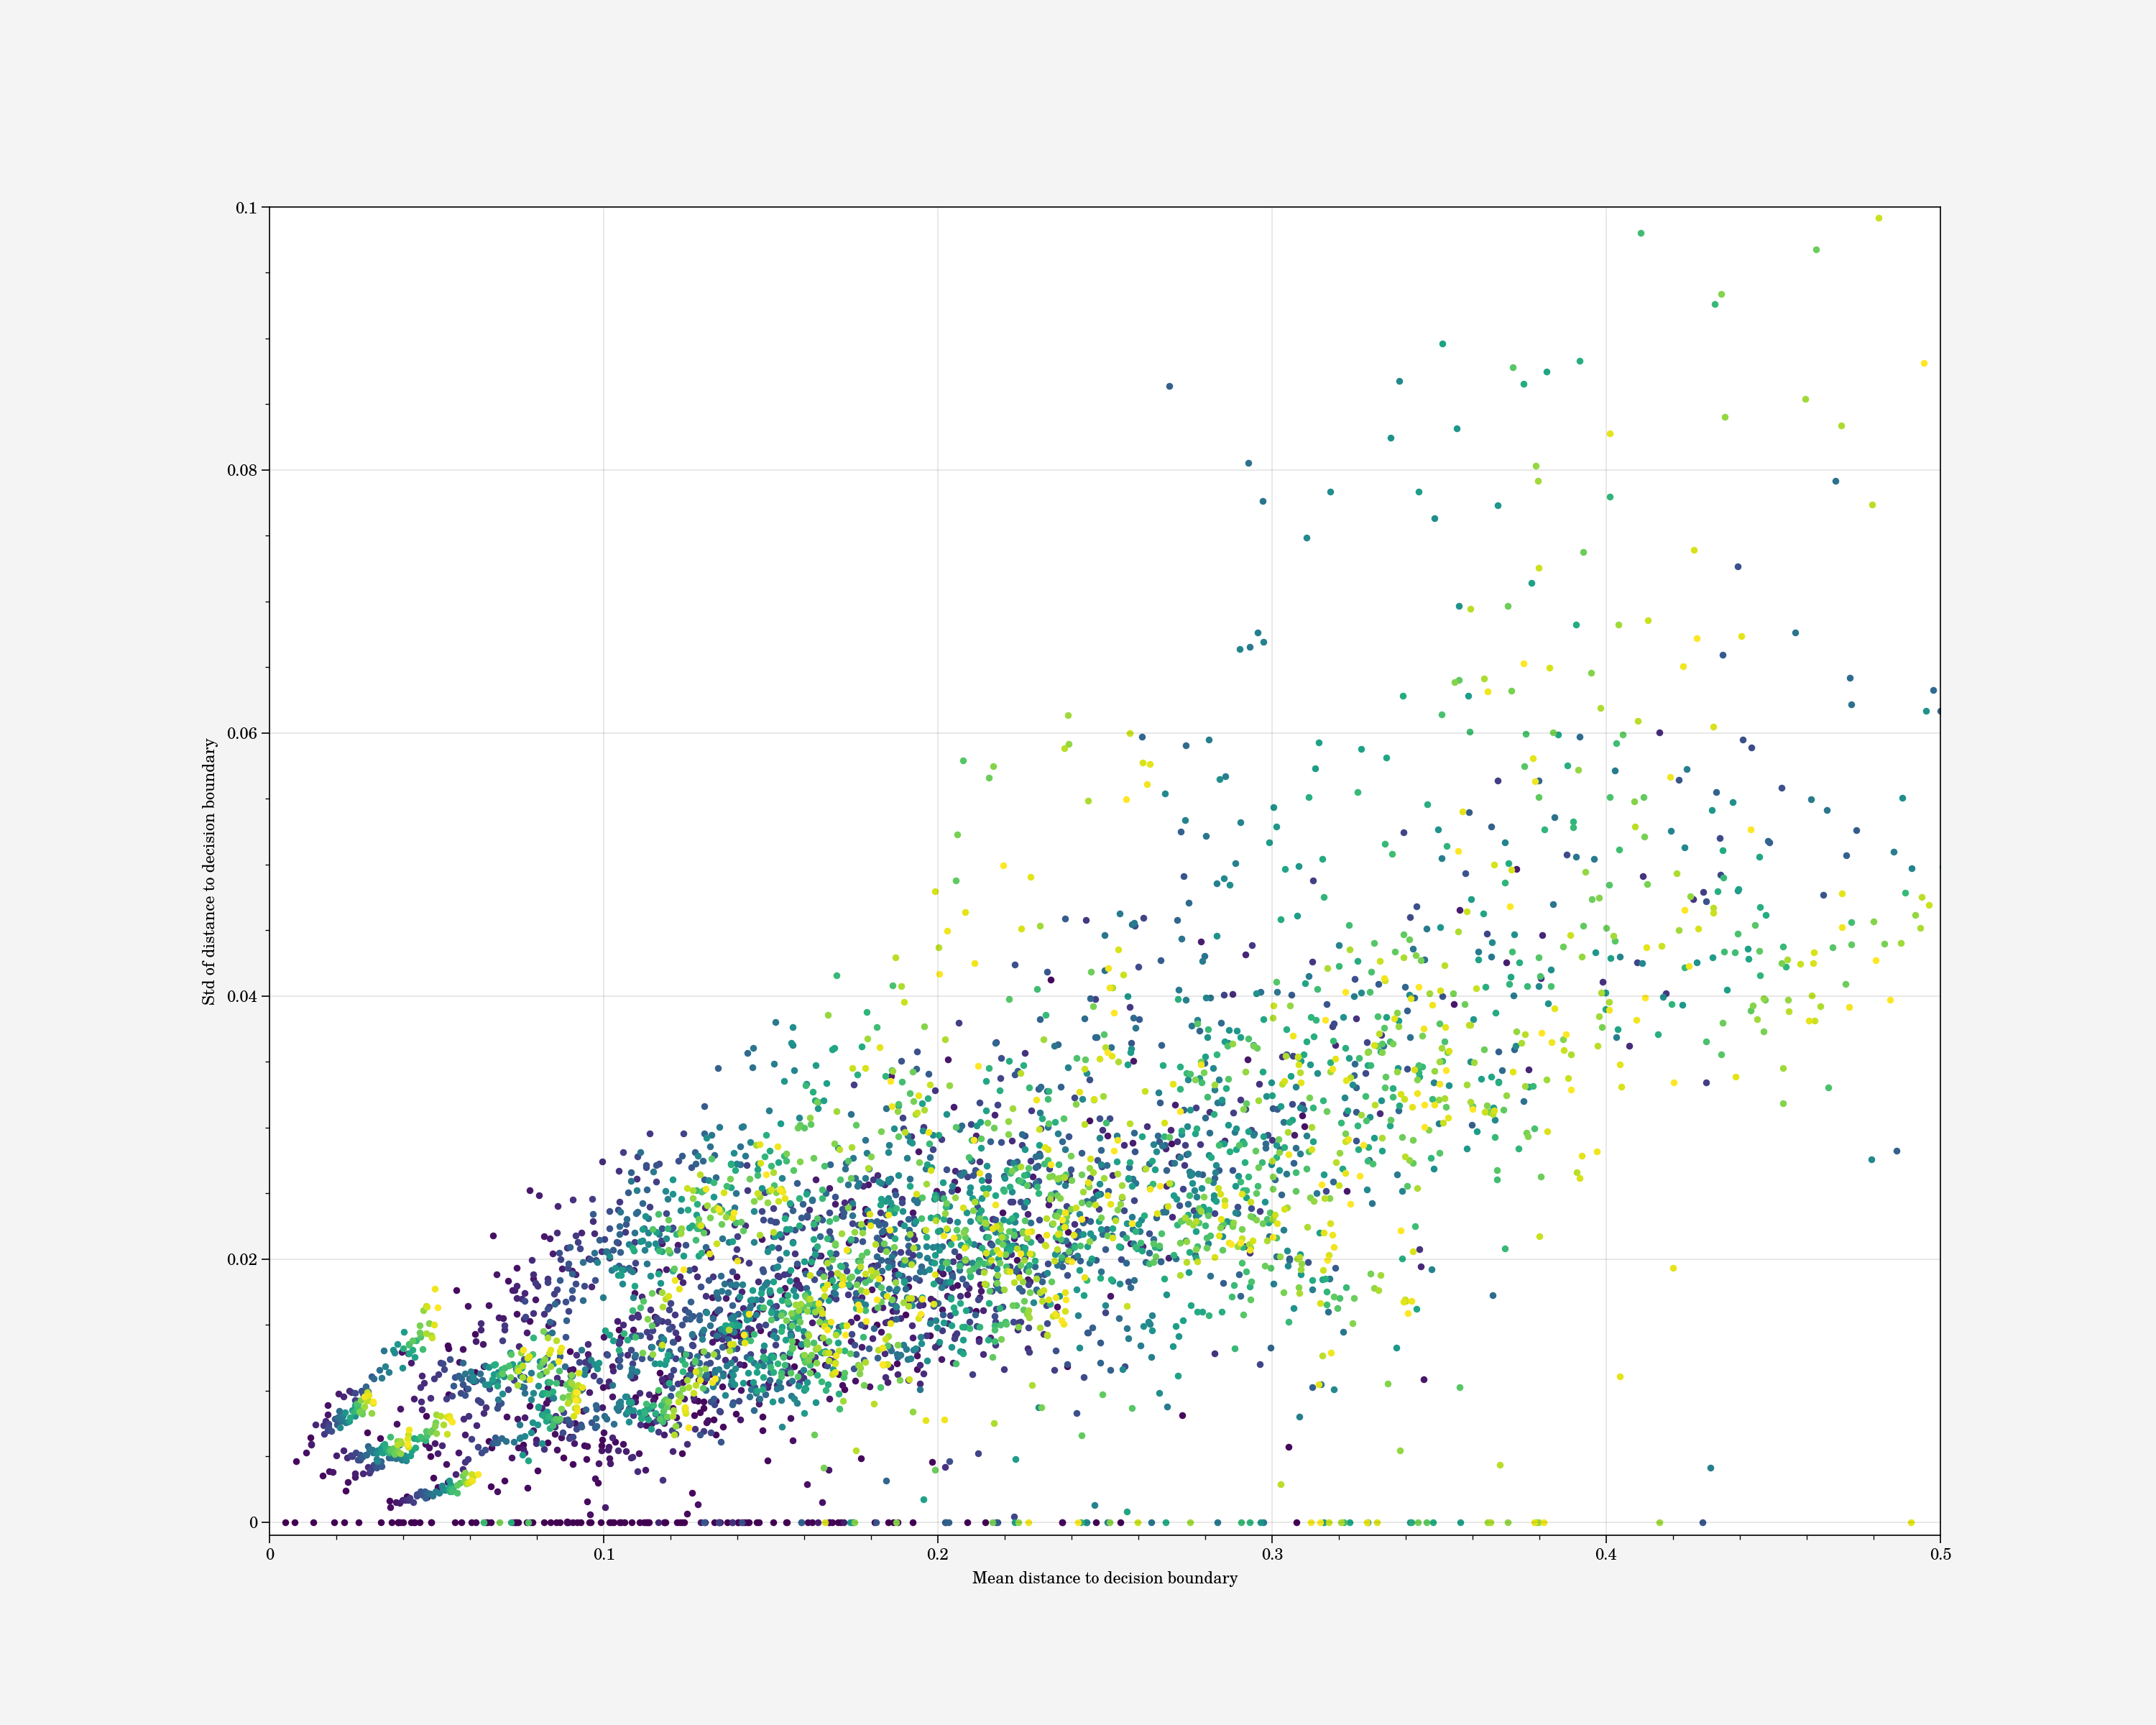

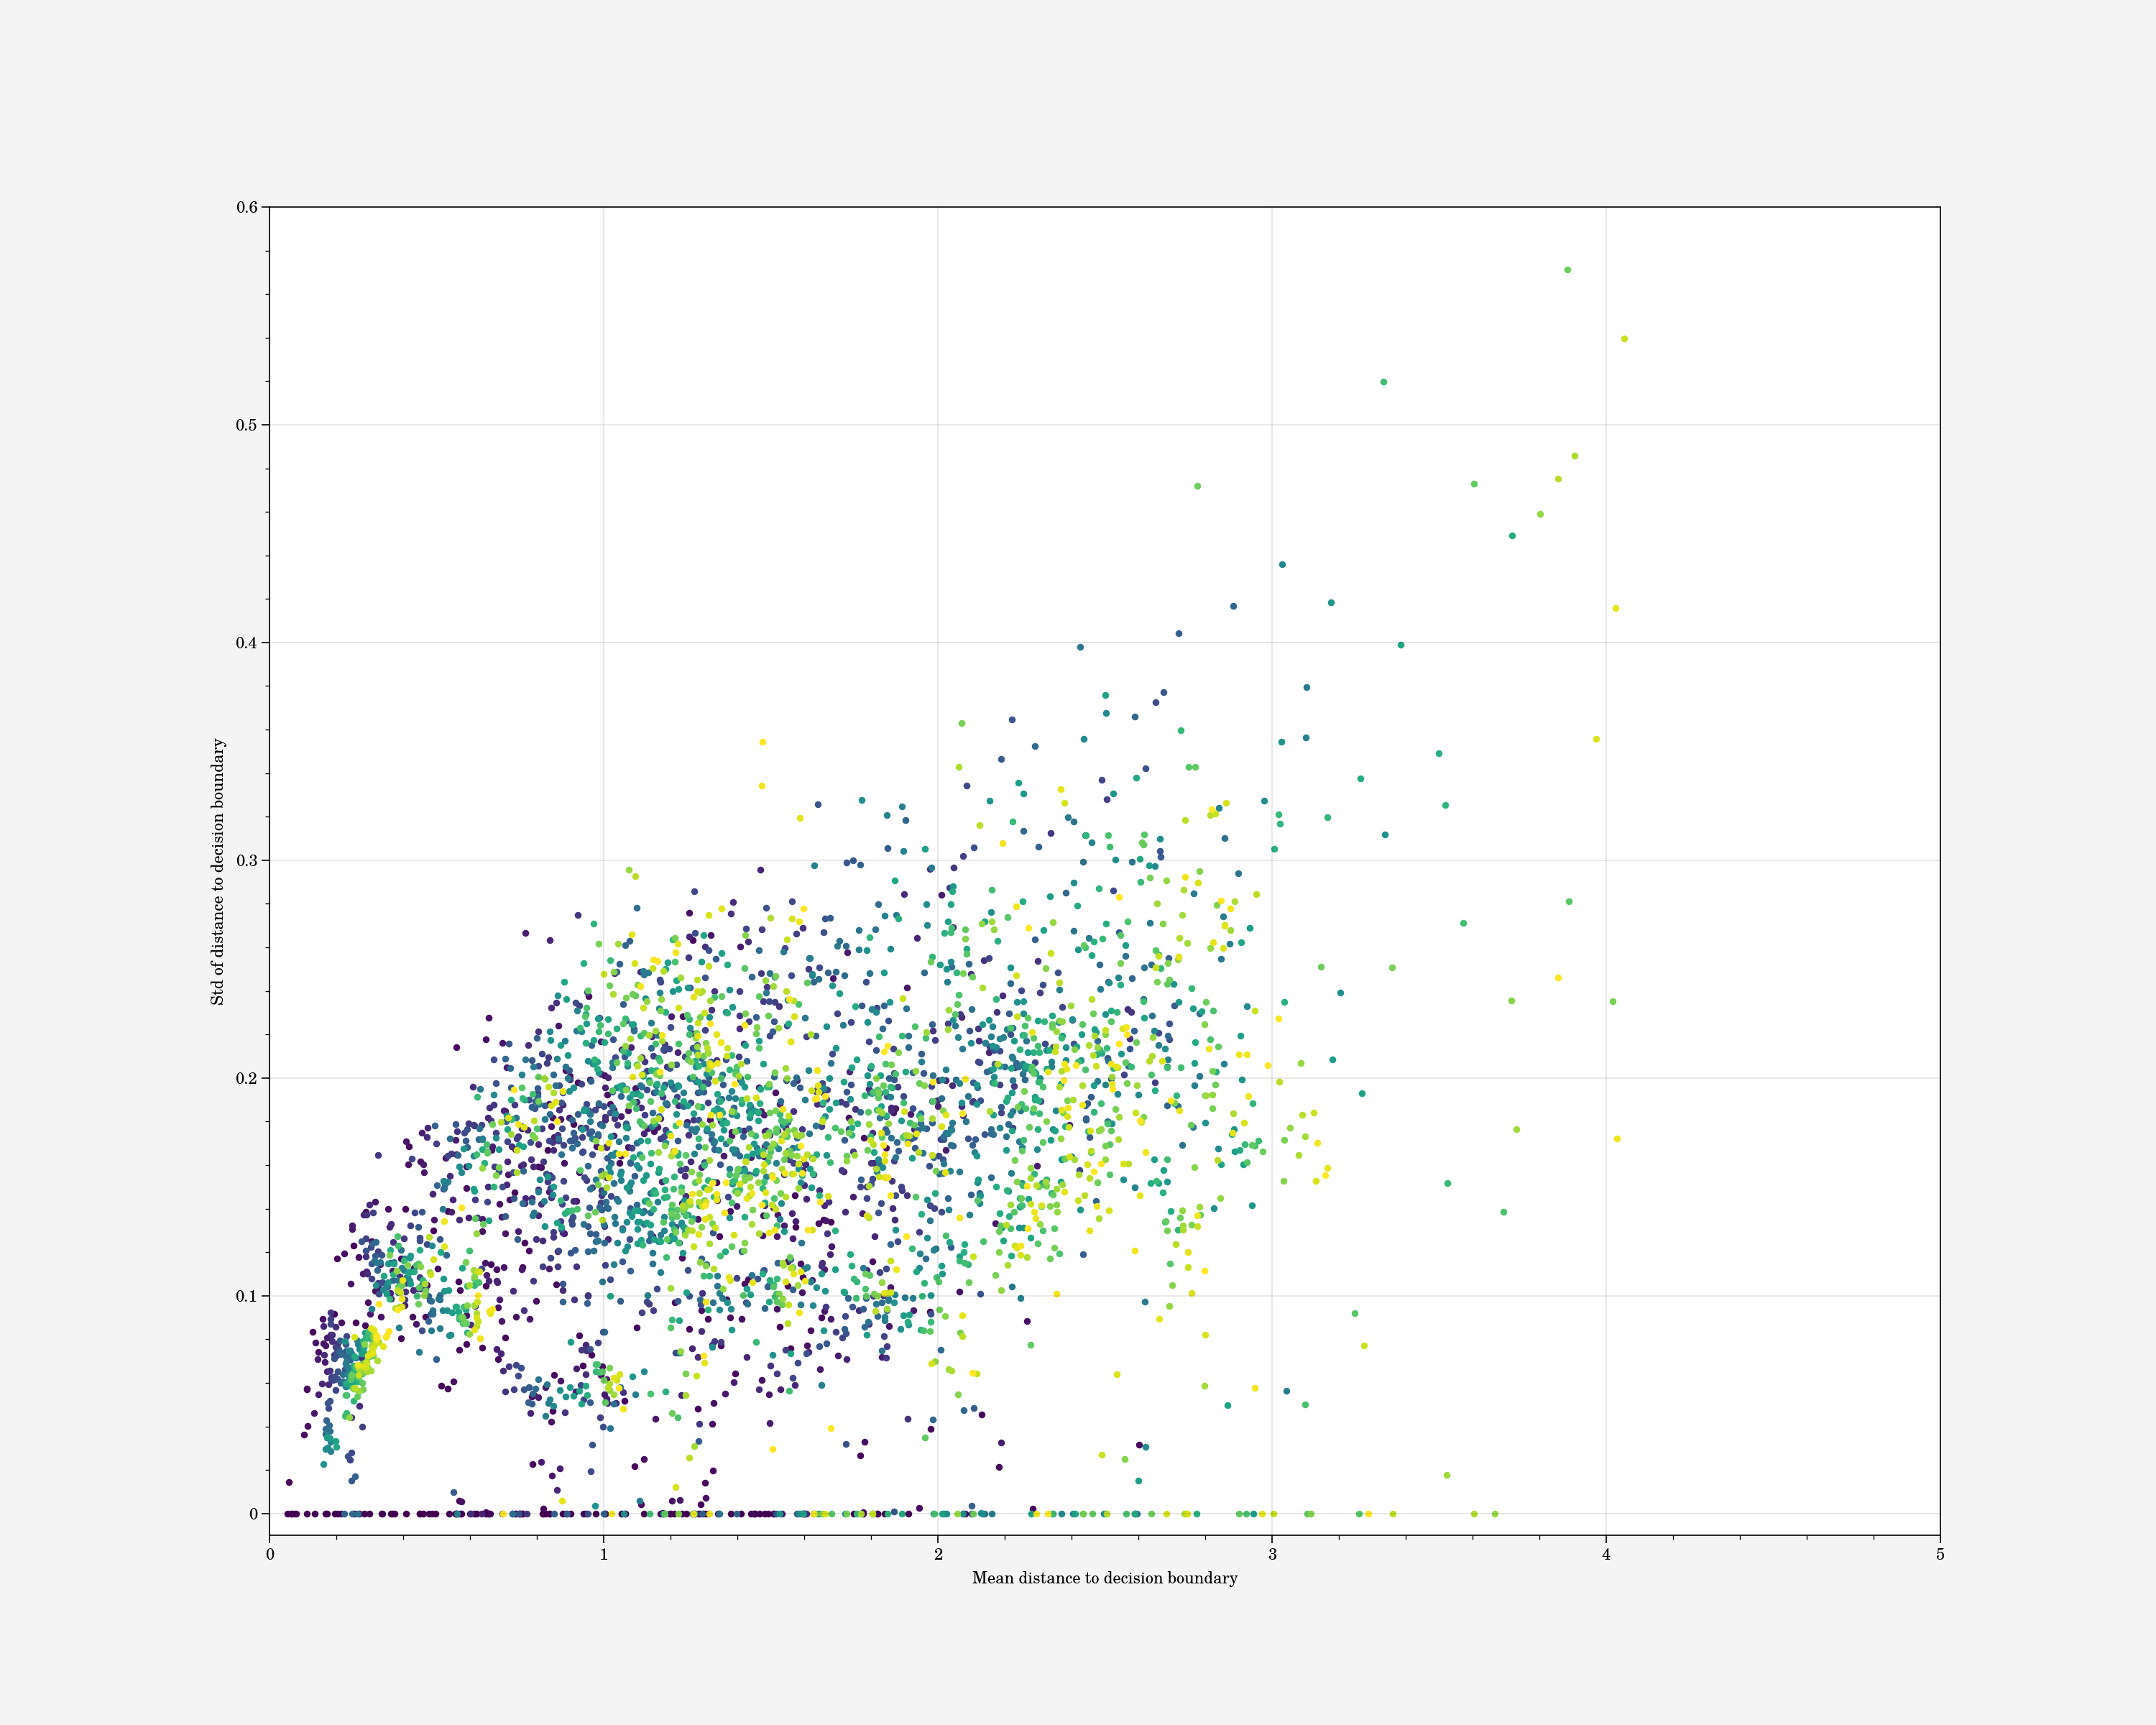

In [74]:
mean_natural = np.nanmean(dists_natural,axis=-1)
mean_robust = np.nanmean(dists_robust,axis=-1)

std_natural = np.nanstd(dists_natural, axis=-1)
std_robust = np.nanstd(dists_robust, axis=-1)

n_dims = 50
col_range = np.linspace(0,1,n_dims, endpoint=True)
cmap=plt.get_cmap('viridis')
colors = [cmap(x) for x in col_range]

plt.figure(figsize=(15,12))
for dim in range(n_dims):
    plt.scatter(mean_natural[:,dim], std_natural[:,dim], s=8, color=colors[dim])
plt.xlabel('Mean distance to decision boundary')
plt.ylabel('Std of distance to decision boundary')
plt.ylim(-.001,.1)
plt.xlim(0,.5)
plt.show()

plt.figure(figsize=(15,12))
for dim in range(n_dims):
    plt.scatter(mean_robust[:,dim], std_robust[:,dim], s=8, color=colors[dim])
plt.xlabel('Mean distance to decision boundary')
plt.ylabel('Std of distance to decision boundary')
plt.ylim(-.01,.6)
plt.xlim(0,5)
plt.show()

In [ ]:
plt.plot(np.arange(1,n_dims+1),np.mean(np.isnan(dists_robust[:8,:n_dims]).sum(-1),axis=0)/dists_robust.shape[-1],'k.')
plt.xlabel('dimension of adversarial space')
plt.ylabel('rate of out of bounds samples')

# Accuracy table

In [64]:
epsilons = [0,0.1,0.25,.5,1,2]
n_dims = 10
all_accs = [epsilons]
n_nat = len(pert_lengths)
n_rob = len(pert_lengths_madry)
accs_nat = []
accs_rob = []
for d in range(n_dims):
    pl_nat = pert_lengths[:,d]
    pl_rob = pert_lengths_madry[:,d]
    accs= np.zeros((len(epsilons),2))
    for i, e in enumerate(epsilons):
        accs[i,0] = .9525 - ((pl_nat<=e).sum()/n_nat*.9525)
        accs[i,1] = .9083 - ((pl_rob<=e).sum()/n_rob*.9083)   
    accs=np.around(accs*100,2)
    accs_nat.append([str(a[0]) + '% /' for a in accs])
    accs_rob.append([str(a[1]) + '%' for a in accs])


In [66]:
for i in range(0,len(accs_nat[0])):
    long_s_nat = np.array(accs_nat)[0,i]
    long_s_rob = np.array(accs_rob)[0,i]
    for s_nat, s_rob in zip(np.array(accs_nat)[1:,i],np.array(accs_rob)[1:,i]) :
        long_s_nat += ' & ' + s_nat 
        long_s_rob += ' & ' + s_rob
    print(long_s_nat + ' \\\\')
    print(long_s_rob + ' \\\\')

95.25% / & 95.25% / & 95.25% / & 95.25% / & 95.25% / & 95.25% / & 95.25% / & 95.25% / & 95.25% / & 95.25% / \\
90.83% & 90.83% & 90.83% & 90.83% & 90.83% & 90.83% & 90.83% & 90.83% & 90.83% & 90.83% \\
51.43% / & 62.86% / & 70.48% / & 76.2% / & 79.06% / & 80.01% / & 81.92% / & 81.92% / & 82.87% / & 83.82% / \\
86.29% & 90.83% & 90.83% & 90.83% & 90.83% & 90.83% & 90.83% & 90.83% & 90.83% & 90.83% \\
1.91% / & 4.76% / & 5.72% / & 6.67% / & 7.62% / & 8.57% / & 9.52% / & 9.52% / & 9.52% / & 10.48% / \\
79.93% & 89.01% & 89.92% & 90.83% & 90.83% & 90.83% & 90.83% & 90.83% & 90.83% & 90.83% \\
0.0% / & 0.0% / & 0.0% / & 0.0% / & 0.0% / & 0.0% / & 0.0% / & 0.0% / & 0.0% / & 0.0% / \\
65.4% & 84.47% & 86.29% & 87.2% & 87.2% & 87.2% & 87.2% & 87.2% & 87.2% & 87.2% \\
0.0% / & 0.0% / & 0.0% / & 0.0% / & 0.0% / & 0.0% / & 0.0% / & 0.0% / & 0.0% / & 0.0% / \\
36.33% & 54.5% & 59.04% & 61.76% & 65.4% & 69.03% & 69.94% & 70.85% & 72.66% & 73.57% \\
0.0% / & 0.0% / & 0.0% / & 0.0% / & 0.0% / & 0.0% 